# Neural network solver for "saprc99" (74 species) mechanism

This notebook is for my AM216 final project report, so it is more organized and self-contained than other notebooks in this folder (which contain my messy experiments). Besides standard Python modules, the only dependency is the KPP module generated by f2py. For the first time using this code, do:

```
$ cd ./strato_code
$ make kpp4py
```

Random seeds are explicitly specified for all stochastic parts (training data sampling, weight initializaion, SGD...), so all results should be reproducible.

**For this big mechanism, training is extremely slow on CPU. I use AWS p2.xlarge to accelarate training by 10x**

# Preparation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
from ipywidgets import interact, IntSlider

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

torch.__version__ # 0.4 has siginificant API change compared to 0.3

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


'0.4.0'

In [2]:
# Make sure GPU is available!!
torch.cuda.is_available() 

True

In [3]:
import saprc99_code.kpp4py as kpp # KPP Fortran integrator, compiled by f2py

# get variable names from source code
from read_results import read_varnames # simple ultility function
nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


# Identify the range of input variables

## A single time series

In [4]:
df_init = pd.Series(data=1e-8, index=varnames)

with open ("saprc99_code/saprc99_Initialize.f90", "r") as f:
    code_str = f.readlines()

for i, line in enumerate(code_str):
    if 'VAR(2)' in line:
        startline = i
    if 'FIX(1)' in line:
        endline = i-1

CFACTOR = 2.447600e+13
for i in range(startline, endline):
    split = code_str[i].split()
    index = int(split[0][4:-1]) - 1 # Fortran -> Python
    valuestr = split[-1]
    # print(index, valuestr)
    df_init[index] = eval(valuestr)

df_init.head()

H2SO4      1.000000e-08
HCOOH      1.657025e+10
CCO_OH     2.839216e+10
RCO_OH     9.594592e+09
CCO_OOH    1.000000e-08
dtype: float64

In [5]:
# Integrate forward for multiple time steps
y_history = kpp.forward(df_init.values, 150)
y_history.shape

(75, 150)

In [6]:
df_history = pd.DataFrame(y_history.T, columns=varnames+['SUN'])
df_history.index.name = 'time'
df_history.head()

,H2SO4,HCOOH,CCO_OH,RCO_OH,CCO_OOH,RCO_OOH,XN,XC,SO2,O1D,...,C_O2,BZCO_O2,RO2_R,NO,NO2,NO3,CCO_O2,RCO_O2,OH,SUN
time,,,,,,,,,,,,,,,,,,,,,
0,2.131631e+10,1.941420e+10,2.994973e+10,1.275993e+10,8.695723e+05,4.160388e+05,5.950410e+07,4.906034e+12,1.202484e+12,0.072945,...,5.696964e+06,2.345523e+04,2.208117e+07,9.000156e+11,1.316153e+12,1.742790e+06,1.555662e+06,6.481562e+05,5.244521e+06,1.000000
1,4.417298e+10,2.437510e+10,3.207181e+10,1.710334e+10,9.292740e+06,4.451212e+06,2.741027e+09,4.931585e+12,1.179627e+12,0.216379,...,1.732457e+07,6.167814e+04,5.346038e+07,3.316187e+11,1.461165e+12,1.491187e+07,4.740948e+06,2.117670e+06,6.089295e+06,0.999220
2,7.278587e+10,2.982455e+10,3.286370e+10,1.871900e+10,7.719766e+07,3.730205e+07,2.363122e+10,5.010350e+12,1.151014e+12,0.391043,...,5.129260e+07,1.530285e+05,1.434036e+08,1.300213e+11,1.092018e+12,4.874537e+07,1.403130e+07,6.473448e+06,8.343999e+06,0.987575
3,1.097681e+11,3.544594e+10,3.363106e+10,1.944317e+10,7.498809e+08,3.586928e+08,7.330606e+10,5.171544e+12,1.114032e+12,0.550368,...,1.797156e+08,4.462390e+05,4.557147e+08,3.906664e+10,5.517341e+11,1.022524e+08,4.947643e+07,2.271533e+07,1.074183e+07,0.938153
4,1.434595e+11,4.025197e+10,3.919870e+10,2.214459e+10,6.370480e+09,2.971199e+09,1.141904e+11,5.302114e+12,1.080340e+12,0.574583,...,5.543973e+08,1.383080e+06,9.960480e+08,8.879201e+09,1.911030e+11,1.165292e+08,1.757165e+08,7.897251e+07,7.788335e+06,0.813302


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


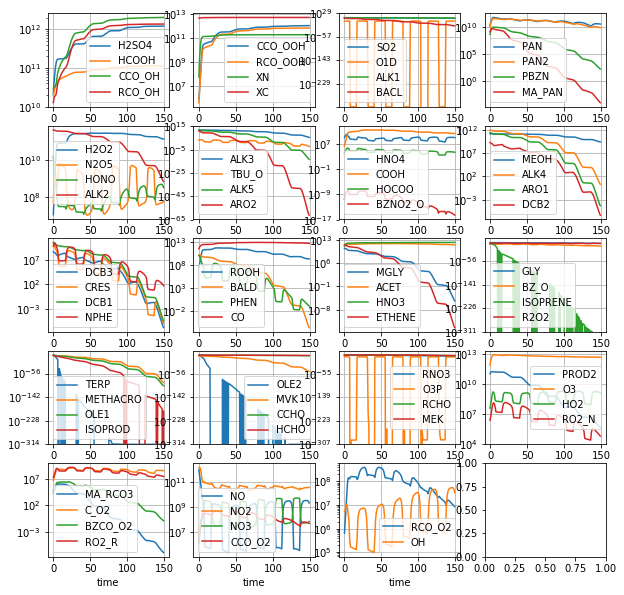

In [7]:
N_sub = 4
N_figures = 20

fig, axes = plt.subplots(N_figures//4, 4, figsize=[10, 10])

for i in range(N_figures-1):
    sub_name = varnames[i*N_sub:(i+1)*N_sub]
    df_history.plot(y=sub_name, logy=True, grid=True, ax=axes.ravel()[i])

In [8]:
df_range = df_history.agg(['min', 'max']).T
df_range.clip_lower(1e-8, inplace=True) # prevent small negative values
df_range.head()

,min,max
H2SO4,2.131631e+10,1.220569e+12
HCOOH,1.941420e+10,1.136111e+11
CCO_OH,2.994973e+10,2.037260e+12
RCO_OH,1.275993e+10,1.376256e+12
CCO_OOH,8.695723e+05,1.160900e+12


## Random sampling from the above range to get y0

In [9]:
# The cost of L-BFGS increases with data size (unlike SGD!)
# Should use GPU for large training data
N_train = 20000

np.random.seed(42)
y0_list =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_train, nvar+1))
y0_list.shape

(20000, 75)

## Integrate for one step (from y0 to y1) to get realistic correlation

In [10]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 19.9 s, sys: 8 ms, total: 19.9 s
Wall time: 19.8 s


(20000, 74)

In [11]:
df_y1 = pd.DataFrame(y1_list, columns=varnames)
df_y1.head()

,H2SO4,HCOOH,CCO_OH,RCO_OH,CCO_OOH,RCO_OOH,XN,XC,SO2,O1D,...,MA_RCO3,C_O2,BZCO_O2,RO2_R,NO,NO2,NO3,CCO_O2,RCO_O2,OH
0,4.937056e+11,1.164822e+11,1.502672e+12,8.354409e+11,1.814492e+11,1.143670e+11,5.500953e+10,5.635373e+12,7.008988e+11,0.307854,...,115653.841066,1.087473e+08,1.116565e+05,1.667207e+08,7.188744e+10,9.506164e+11,8.139994e+07,2.977252e+07,6.605769e+06,1.010181e+07
1,8.966430e+11,9.995743e+10,1.833578e+11,5.096011e+11,1.355363e+11,6.330318e+11,1.612448e+11,5.246032e+12,7.839067e+10,0.126851,...,200329.460217,1.640665e+08,4.016099e+05,3.902192e+08,1.315730e+10,5.036233e+11,2.240616e+08,4.805304e+07,2.601526e+07,3.514818e+06
2,1.113113e+12,4.906869e+10,3.223967e+11,6.835724e+11,1.144337e+12,1.774033e+11,2.179172e+11,5.680885e+12,2.856617e+11,0.137609,...,163398.550181,5.384969e+07,4.116502e+04,1.068038e+08,3.522374e+10,1.489255e+12,3.324025e+08,1.485414e+07,5.041450e+06,2.532494e+06
3,3.160307e+11,1.159530e+11,8.223115e+11,1.235956e+12,7.328723e+11,5.828988e+11,1.719655e+11,5.515935e+12,5.917751e+11,0.031147,...,527898.649452,7.635691e+07,1.327572e+05,3.732986e+08,3.469246e+09,3.719307e+11,4.580194e+08,1.104738e+07,2.472973e+07,7.418328e+05
4,8.619731e+10,7.575917e+10,1.118727e+12,8.906125e+11,8.430989e+11,7.162606e+11,1.216575e+11,5.182678e+12,9.539587e+11,0.034695,...,756357.070112,1.016421e+08,1.023802e+06,5.656576e+08,1.252116e+09,2.179948e+11,7.545920e+08,1.083240e+07,6.721065e+07,6.235707e+05


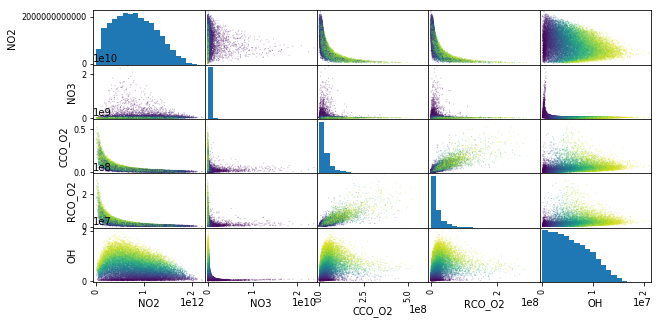

In [12]:
# just plot a subset of species
pd.plotting.scatter_matrix(df_y1.iloc[:,-5:], c=y0_list[:,-1], figsize=(10, 5), alpha=0.3, s=5, hist_kwds={'bins': 20});
# color is SUN intensity at the previous time step

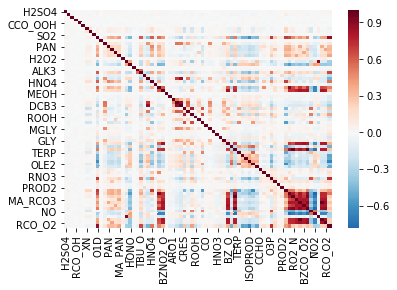

In [13]:
sns.heatmap(df_y1.corr(), cmap='RdBu_r', center=0.0)
# correlation in tropospheric VOC mechanism is not as strong as in strato mechanism

## See if the distribution of y1 is representative enough

In [14]:
# Integrate for one more step to see if there's any significant change in species distribution
np.random.seed(41)
SUN_new = np.random.rand(N_train, 1) # use new sun intensity
%time y2_list = kpp.onestep(np.c_[y1_list, SUN_new].T).T  
y2_list.shape

CPU times: user 12.1 s, sys: 4 ms, total: 12.1 s
Wall time: 12.1 s


(20000, 74)

In [15]:
# No significant change in species distribution
# Too many species, better explore interactively
@interact(n=IntSlider(min=0,max=nvar-1,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=73), Output()), _dom_classes=('widget-interact',…

## Estimate the dimensionality of manifold

Use PCA as a quick and dirty estimate. Any better (non-linear) dimensionality estimate algorithm?

In [16]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [17]:
# Normalize data and apply PCA
# http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
Normed_PCA = lambda : make_pipeline(StandardScaler(), PCA(n_components=10))

In [18]:
def print_PCA(y_list):
    pca = Normed_PCA()
    pca.fit(y_list)
    ratio = pca.named_steps['pca'].explained_variance_ratio_
    print('Explained variance: \n', ratio)
    print('Accumulated: \n', np.cumsum(ratio))

In [19]:
print_PCA(y0_list) # evenly distributed due to uniform sampling

Explained variance: 
 [0.0145045  0.01433865 0.01419589 0.01406828 0.01397366 0.01391901
 0.01387446 0.01380507 0.01378899 0.01372506]
Accumulated: 
 [0.0145045  0.02884315 0.04303904 0.05710732 0.07108098 0.08499999
 0.09887445 0.11267951 0.12646851 0.14019357]


In [20]:
print_PCA(y1_list) # Dominated by the first 5 components

Explained variance: 
 [0.17716936 0.08105821 0.06706682 0.05574279 0.02551821 0.02148649
 0.0203775  0.01873108 0.01652386 0.01572998]
Accumulated: 
 [0.17716936 0.25822757 0.32529439 0.38103718 0.40655539 0.42804188
 0.44841938 0.46715046 0.48367433 0.4994043 ]


In [21]:
print_PCA(y2_list) # No Significant change compared to y2

Explained variance: 
 [0.18572479 0.08896373 0.06767162 0.06075423 0.03104963 0.0235087
 0.02311311 0.02105835 0.01891771 0.01741447]
Accumulated: 
 [0.18572479 0.27468852 0.34236014 0.40311437 0.434164   0.4576727
 0.48078581 0.50184415 0.52076186 0.53817633]


# Preprocessing

Neural network requires input features to be normalized.

In [22]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:nvar]) # skip SUN, which is already in 0~1

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
X_train = np.c_[normalizer.transform(y1_list[:,0:nvar]), SUN_new]
X_train.shape

(20000, 75)

In [24]:
Y_train = normalizer.transform(y2_list) # use y1's scale
Y_train.std(axis=0) # highly normalized since y1 and y2 have similar distribution.

array([1.00089713, 1.00553239, 1.00008706, 0.99996237, 1.00019926,
       1.00006725, 1.00485181, 1.00547489, 0.98068464, 1.05803788,
       0.99463313, 0.98612211, 1.00792552, 1.07537982, 1.05483601,
       1.07830626, 0.96971057, 0.88416033, 0.49876183, 0.97949115,
       0.95548791, 0.95771247, 0.86729943, 0.72471061, 1.02757315,
       0.90399226, 1.08455496, 1.10685775, 0.98155236, 0.92619323,
       0.90029961, 0.8949195 , 0.77761087, 0.52245153, 0.88840616,
       0.73979859, 0.87914218, 0.8227317 , 0.37260044, 0.99787369,
       0.89476353, 1.00216642, 1.02278366, 0.84173782, 0.88608193,
       1.09984887, 0.25969387, 1.25383276, 0.11560654, 0.6689828 ,
       0.57206748, 0.49947035, 0.19367886, 0.76263325, 0.82301459,
       0.80813859, 0.94867281, 0.83025841, 0.82333424, 0.97801586,
       0.90989873, 0.95797673, 1.13692293, 1.23201091, 1.64102942,
       1.6446337 , 1.83446008, 1.29907764, 0.6949734 , 0.90917361,
       1.14698007, 1.80862819, 1.98363726, 1.02024214])

# ANN training

In [25]:
device = torch.device('cuda')
device

device(type='cuda')

In [26]:
# use torch.from_numpy() to share the same memory.
#x_torch = torch.from_numpy(X_train)
#y_torch = torch.from_numpy(Y_train)

# use GPU!
x_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_torch = torch.tensor(Y_train, dtype=torch.float32).to(device)

In [27]:
# two-hidden-layer net performs significantly better than one-hidden-layer net
def two_layer_net(H=300):
    model = torch.nn.Sequential(
        torch.nn.Linear(nvar+1, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, nvar)
    )
    return model 

In [28]:
# weight initialization has no significant effect
# presumably because the net is quite small so it is easy to find minimum
torch.manual_seed(40) 

# model = two_layer_net().double() # L-BFGS doesn't work at single precision on CPU. Not sure why.
model = two_layer_net().to(device) # L-BFGS works at single precision on GPU.

In [29]:
%%time
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters())
for t in range(1000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%50==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        
        print(t+1, loss.item())

50 0.00203488627448678
100 0.001152560580521822
150 0.0008438009535893798
200 0.0006820010603405535
250 0.000579445157200098
300 0.0005089616752229631
350 0.0004555756750050932
400 0.00041410510311834514
450 0.00038108968874439597
500 0.0003549028479028493
550 0.00033260529744438827
600 0.0003131301491521299
650 0.00029629224445670843
700 0.0002816204505506903
750 0.0002700221084523946
800 0.0002582541201263666
850 0.00024878105614334345
900 0.00023991680063772947
950 0.0002321805659448728
1000 0.00022549541608896106
CPU times: user 12min 24s, sys: 2min 18s, total: 14min 43s
Wall time: 14min 43s


In [30]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.detach().cpu().numpy() # 100x faster than KPP on CPU; 1000x faster than GPU

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 5.84 ms


In [31]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99995669, 0.99992481, 0.99996981, 0.99996825, 0.99996821,
       0.99996819, 0.99993171, 0.99993539, 0.99995444, 0.99991623,
       0.99996375, 0.99975845, 0.99983371, 0.99982346, 0.99977579,
       0.99975849, 0.99991127, 0.99950936, 0.99898399, 0.99995106,
       0.99994607, 0.999716  , 0.99988895, 0.99977384, 0.99958241,
       0.99986877, 0.99966491, 0.99942211, 0.9999479 , 0.99991843,
       0.99991167, 0.99964047, 0.999127  , 0.9985145 , 0.99973728,
       0.99931107, 0.99983172, 0.99980246, 0.9979794 , 0.99996363,
       0.9997802 , 0.9999514 , 0.99995182, 0.99985415, 0.99976803,
       0.99960223, 0.99219773, 0.99972854, 0.97783691, 0.99965231,
       0.99934949, 0.99835164, 0.98981667, 0.99967346, 0.9997296 ,
       0.9997637 , 0.99987678, 0.99989101, 0.99973695, 0.99993399,
       0.99982948, 0.99992129, 0.99983414, 0.99968011, 0.99973636,
       0.99983998, 0.9997858 , 0.99980947, 0.9995981 , 0.99990326,
       0.99976485, 0.99985568, 0.99982185, 0.99976288])

In [32]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9997755124259049

## Scale-back to original concentration

In [33]:
y_pred_origin = normalizer.inverse_transform(y_pred_numpy)

In [34]:
def error_norm(y, y_true):
    """L1 error norm"""
    abserr = (np.abs(y - y_true)).mean(axis=0)
    return abserr/y_true.mean(axis=0)

In [35]:
L2_train = error_norm(y_pred_origin, y2_list) # train error varies across species
L2_train.mean()

0.021333938711705643

## Accuracy on test set

In [36]:
N_test = 5000

np.random.seed(39)
y0_test =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_test, nvar+1))
%time y1_test = kpp.onestep(y0_test.T).T
y1_test.shape # this is the initial condition

CPU times: user 5.1 s, sys: 8 ms, total: 5.11 s
Wall time: 4.92 s


(5000, 74)

In [37]:
np.random.seed(38)
SUN_test = np.random.rand(N_test, 1) # use new sun intensity
%time y2_test = kpp.onestep(np.c_[y1_test, SUN_test].T).T
y2_test.shape

CPU times: user 3 s, sys: 0 ns, total: 3 s
Wall time: 2.99 s


(5000, 74)

In [38]:
X_test = np.c_[normalizer.transform(y1_test), SUN_test]
Y_test = normalizer.transform(y2_test) # true result for comparison

#Y_test_pred = model(torch.from_numpy(X_test)).detach().numpy()
Y_test_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().cpu().numpy()

In [39]:
r2_test = r2_score(Y_test_pred, Y_test, multioutput='raw_values')
r2_test 

array([0.99995149, 0.99990877, 0.99996502, 0.99995495, 0.99996041,
       0.99996448, 0.99990266, 0.99991529, 0.99994444, 0.99990234,
       0.99995714, 0.99968725, 0.99979697, 0.99974179, 0.99969285,
       0.99961765, 0.99988242, 0.99827285, 0.99836185, 0.99993498,
       0.99993573, 0.99958332, 0.99986242, 0.99969994, 0.9993202 ,
       0.99983808, 0.99943337, 0.98654046, 0.99993602, 0.99990425,
       0.99988595, 0.99944037, 0.99816538, 0.9977206 , 0.99966593,
       0.99904676, 0.99979   , 0.99976873, 0.99531202, 0.99995643,
       0.99971223, 0.99993963, 0.99994398, 0.99981997, 0.99969313,
       0.99872362, 0.96407416, 0.9993629 , 0.92422791, 0.99948478,
       0.99913054, 0.99664274, 0.94415477, 0.99946594, 0.99963279,
       0.99969739, 0.99984827, 0.99984587, 0.9996437 , 0.99992295,
       0.99977887, 0.99990772, 0.99976868, 0.99928126, 0.99892965,
       0.99964526, 0.99869572, 0.99964587, 0.99937976, 0.99988998,
       0.99842308, 0.99962857, 0.99954607, 0.9997409 ])

In [40]:
r2_test.min(), r2_test.argmin() # for worse case

(0.9242279062822185, 48)

In [41]:
varnames[48] # TERP has a weird, long-tail probability distribution, so has much larger error.

'TERP'

In [42]:
r2_score(Y_test_pred, Y_test, multioutput='variance_weighted')

0.9992930402553365

In [43]:
y2_test_pred = normalizer.inverse_transform(Y_test_pred)
y2_test_pred.shape

(5000, 74)

In [44]:
L1_test = error_norm(y2_test_pred, y2_test) # test error varies across species
L1_test

array([2.79595258e-03, 2.47519614e-03, 2.45390337e-03, 2.52575212e-03,
       2.62010087e-03, 2.54586735e-03, 2.50772392e-03, 2.50851931e-04,
       3.09795243e-03, 5.00809116e-03, 1.84720888e-03, 5.91160428e-03,
       3.67831733e-03, 3.99227174e-03, 4.66532123e-03, 4.98873250e-03,
       3.88835918e-03, 4.37690477e-02, 2.09409930e-02, 3.24727180e-03,
       3.24623893e-03, 1.22055257e-02, 5.18125628e-03, 9.42545846e-03,
       7.29832431e-03, 5.03337926e-03, 1.01062494e-02, 2.80810643e-02,
       3.19872043e-03, 4.09195347e-03, 4.32392875e-03, 7.49422802e-03,
       1.20444385e-02, 3.08440319e-02, 5.33842983e-03, 1.96672051e-02,
       5.48724491e-03, 4.05564271e-03, 4.89406187e-02, 2.27750680e-03,
       4.31652366e-03, 1.82501249e-03, 2.14926675e-03, 5.77397291e-03,
       3.89124972e-03, 2.00701354e-02, 1.64272302e-01, 1.07059107e-02,
       7.84808886e-01, 1.24055667e-02, 1.70204587e-02, 3.52376033e-02,
       2.97072527e-01, 8.08399524e-03, 3.55147295e-03, 3.20072044e-03,
      

In [45]:
L1_test.mean()

0.025622577576167226

In [46]:
L1_test.max(), L1_test.argmax()

(0.7848088860796625, 48)

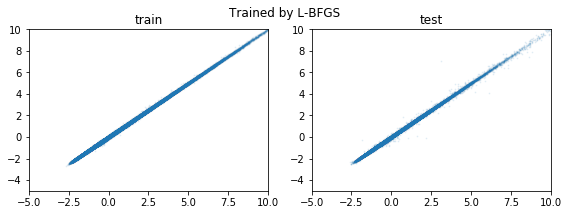

In [47]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(y_pred_numpy, Y_train, s=0.5, alpha=0.1)
axes[0].set_title('train')
axes[0].set_xlim(-5, 10); axes[0].set_ylim(-5, 10)

axes[1].scatter(Y_test_pred, Y_test, s=0.5, alpha=0.1)
axes[1].set_title('test')
axes[1].set_xlim(-5, 10); axes[1].set_ylim(-5, 10)

fig.suptitle('Trained by L-BFGS')
fig.tight_layout()

In [48]:
# Interactively plot the error for each species
@interact(i_var=IntSlider(min=0,max=nvar-1,step=1,value=48,continuous_update=True))
def plot_one_species(i_var):
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])
    axes[0].scatter(y_pred_numpy[:,i_var], Y_train[:,i_var], alpha=0.5, s=1)
    axes[0].set_title('train')
    axes[1].scatter(Y_test_pred[:,i_var], Y_test[:,i_var], alpha=0.5, s=1)
    axes[1].set_title('test')
    fig.suptitle(varnames[i_var])

interactive(children=(IntSlider(value=48, description='i_var', max=73), Output()), _dom_classes=('widget-inter…

# ANN prediction for multiple time steps

In [49]:
SUN_history = df_history['SUN']
SUN_history.shape

(150,)

In [50]:
X0 = np.c_[normalizer.transform(y1_test), np.ones(N_test)*SUN_history[0]]

In [51]:
def predict_multistep(y_init, Nt, model=model):
    '''
    y_init : [n_sample, nvar]
    Use global variable SUN_history as the forcing term'''    
    N_sample = y_init.shape[0] # N_sample*Nt should not be too large
    Y_history = np.empty([Nt, N_sample, nvar])
    
    X = np.c_[normalizer.transform(y_init), np.ones(N_sample)*SUN_history[0]]
    for t in range(Nt-1):
        
        # Y = model(torch.from_numpy(X)).detach().numpy()
        Y = model(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()
        
        Y_history[t] = Y # record normalized result. Need to scale back later
        
        X = np.c_[Y, np.ones(N_sample)*SUN_history[t]]

    return Y_history

In [52]:
n_sample = 500
n_time = 10
%time y_pred_test_history = predict_multistep(y1_test[0:n_sample,:], n_time)
#normalizer.inverse_transform(y_pred_test_history, copy=False)
y_pred_test_history.shape

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 9.81 ms


(10, 500, 74)

In [53]:
%%time
y_test_history = np.empty_like(y_pred_test_history)
for i in range(n_sample):
    y_test_history[:,i,:] = kpp.forward(y1_test[i,:], n_time).T[:, :-1]
normalizer.transform(y_test_history.reshape(-1, nvar), copy=False);

CPU times: user 2.85 s, sys: 4 ms, total: 2.86 s
Wall time: 2.7 s


Text(0.5,1.05,'Integrate for multiple steps; Trained by L-BFGS')

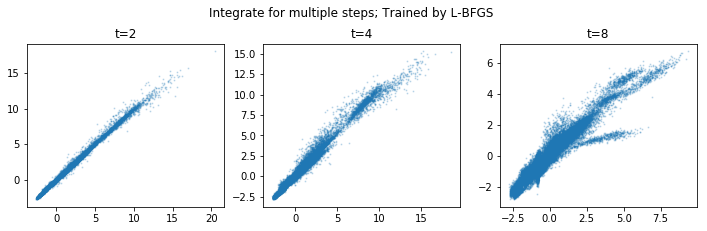

In [54]:
plt.figure(figsize=[12, 3])
for i, t in enumerate([2, 4, 8]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_history[t], y_pred_test_history[t], s=1, alpha=0.2)
    plt.title(f't={t}')
    
plt.suptitle('Integrate for multiple steps; Trained by L-BFGS', y=1.05)